# Planet detections

This notebook uses the distribution of detectable planets around white dwarfs $\frac{d^2N_{det}}{dloga\,dlogM}$ with $1M_\odot$ progenitors to predict the number of planets Gaia will detect around white dwarfs.

The calculation is as follows:
$\frac{d^2N_{det}}{dloga\,dlogM}=\left(\frac{d^2N_{WD}}{dloga\,dlogM}\right)_{jk}P_{jk}$ 
where $P_{jk}$ is the detection probability of a planet in the $j^{th}$ semi-major axis bin and $k^{th}$ mass bin. This is done in main.py in the detections folder.

$N_{det}=\Sigma_{jk}\left(\frac{d^2N_{det}}{dloga\,dlogM}\right)_{jk}(dloga)_j(dlogM)_k$

The errors are given by 

$\sigma(\frac{d^2N_{det}}{dloga\,dlogM})_{jk}=P_{jk}\sigma(\frac{d^2N_{WD}}{dloga\,dlogM})_{jk}$

$\sigma(N_{det})=\sqrt{\Sigma_{jk}\left(\frac{d^2N_{det}}{dloga\,dlogM}\right)_{jk}^2}$ as the error on the detection probabilities is an order of magnitude smaller than the error on the number of planets per log M and log a so can be neglected.

**Ongoing issues**

None to report

## Table of Contents:  <a class="anchor" id="top"></a>
* [Set up](#set-up)
    + [Import modules](#import)
    + [Import data](#data)
* [Transform data](#transform)
    + [Useful functions](#function)
    + [Convert for plotting](#convert)
* [Plot](#plot)
* [Number of detected planets](#number)
    * [Summary stats](#summary)
* [White dwarfs brighter than Gmag 15](#gmag-15)

## Set-up <a class="anchor" id="set-up"></a>
<p align="right">(<a href="#top">back to top</a>)</p>

### Import modules  <a class="anchor" id="import"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

### Import data  <a class="anchor" id="data"></a>

Load detection map. Have upper and lower error maps due to non-linear relation between S/N and detection probability.

In [2]:
name='enoise' #use to change if you are importing data for whole catalogue or just Gmag 15
plan_det=np.loadtxt('Detection_probability/Results/Distributions/detected_planets_{}.csv'.format(name),delimiter=',')
plan_error_up=np.loadtxt('Detection_probability/Results/Distributions/upper_error_planets_{}.csv'.format(name),delimiter=',')
plan_error_low=np.loadtxt('Detection_probability/Results/Distributions/lower_error_planets_{}.csv'.format(name),delimiter=',')

Load histogram edges

In [3]:
a_edges_wd=np.loadtxt('Distribution/wd_a_edges.csv',delimiter=',')
m_edges_wd=np.loadtxt('Distribution/wd_m_edges.csv',delimiter=',')

## Transform data <a class="anchor" id="transform"></a>
<p align="right">(<a href="#top">back to top</a>)</p>

### Useful functions <a class="anchor" id="function"></a>

In [4]:
def dist_convert(hist_val,edge1,edge2):
    """
    Function  to return values in 2d histogram weighted by dloga and dlogm
    :params hist_val: array, values from np.histogram
    :params edge1: array, bin edges in 1st dimension, unevenly distributed in log space, unlogged values
    :params edge2: array, bin edges in 2nd dimension, unevenly distributed in log space, logged values
    
    :returns hist_val_scaled: array, values in original histogram weighted by dloga and dlogm where both logs are base 10
    """
    dloga=np.log10(np.exp(1))*2*np.ediff1d(edge1)/(edge1[:-1]+edge1[1:]) #dloga=log10(e) da/a - find a from averaging sucessive values
    dlogm=np.ediff1d(edge2) #dlogm need to account for non uniform spacing
    hist_val_scaled=np.zeros([len(edge1)-1,len(edge2)-1])
    for i in range(len(edge2)-1):
        hist_val_scaled[:,i]=hist_val[:,i]*dloga*abs(dlogm[i]) #have to multiply by bin width as doing a discrete integral, take absolute value as dlogm can be negative
    
    return hist_val_scaled

In [5]:
def plot_convert(hist_val,edge1,edge2):
    """
    Function  to return values in 2d histogram converted to d^2N/da dlogM
    :params hist_val: array, values from np.histogram
    :params edge1: array, a bin edges in 1st dimension, unevenly distributed in log space, unlogged values
    :params edge2: array, bin edges in 2nd dimension, evenly distributed in log space, log values
    
    :returns hist_val_scaled: array, values in original histogram weighted by a/log10(e)
    """
    amid=(edge1[:-1]+edge1[1:])/2 #find a from averaging sucessive values
    hist_val_scaled=np.zeros([len(edge1)-1,len(edge2)-1])
    for i in range(len(edge2)-1):
        hist_val_scaled[:,i]=hist_val[:,i]*amid/np.log10(np.exp(1))
    
    return hist_val_scaled

### Convert for plotting <a class="anchor" id="convert"></a>

In [6]:
plan_plot=plot_convert(plan_det,a_edges_wd,m_edges_wd)

In [7]:
a_edges_wd[28]

3.9148676411688634

## Plot of detected planets <a class="anchor" id="plot"></a>
<p align="right">(<a href="#top">back to top</a>)</p>

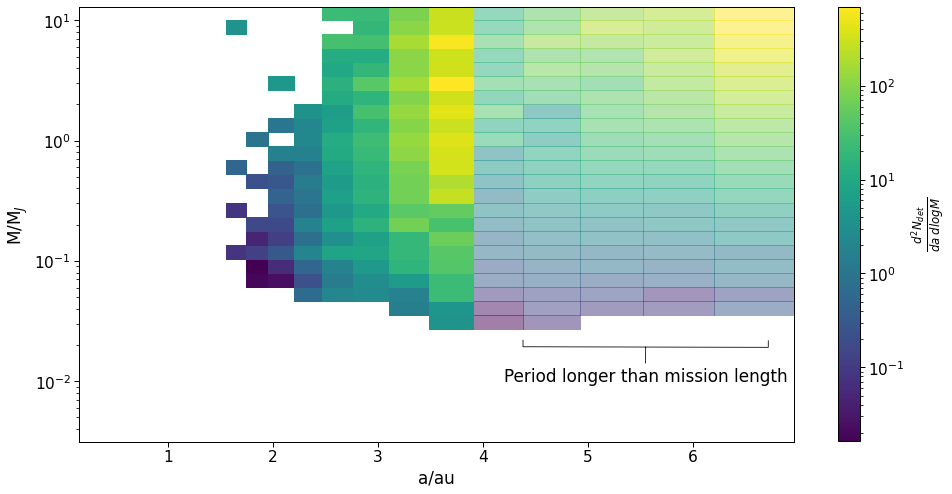

In [8]:
with sns.plotting_context('paper',font_scale=1.75):
    plt.figure(figsize=[16,8])
    plt.pcolormesh(a_edges_wd[28:],10**m_edges_wd,np.transpose(plan_plot[28:,:]),norm=mcolors.LogNorm(),shading='flat',alpha=0.5)
    plt.pcolormesh(a_edges_wd[:29],10**m_edges_wd,np.transpose(plan_plot[:28,:]),norm=mcolors.LogNorm(),shading='flat',alpha=1)
    plt.yscale('log')
    plt.xlabel('a/au')
    plt.ylabel('M/M$_J$')
    plt.annotate('Period longer than mission length',(5.552,10**(-1.7)),(4.2,1e-2),arrowprops=dict(arrowstyle='-[, widthB=7.3, lengthB=0.4'))
    #plt.title('Predicted number of detected planets per log semi-major axis \n and log M over entire eDR3 white dwarf catalogue')
    plt.colorbar(label=r'$\frac{d^2N_{det}}{da\;dlogM}$')
    #plt.savefig('../Plots/distribution_of_detected_planets_{}.pdf'.format(name),bbox_inches='tight')

## Number of detected planets <a class="anchor" id="number"></a>
<p align="right">(<a href="#top">back to top</a>)</p>

First find total number

In [9]:
plan_num=np.sum(dist_convert(plan_det,a_edges_wd,m_edges_wd))
error_num_up=np.sqrt(np.sum(dist_convert(plan_error_up,a_edges_wd,m_edges_wd)**2))
error_num_low=np.sqrt(np.sum(dist_convert(plan_error_low,a_edges_wd,m_edges_wd)**2))

In [10]:
print('Gaia will find {:.1f} + {:.1f} - {:.1f} planets around white dwarfs'.format(plan_num,error_num_up,error_num_low))

Gaia will find 118.5 + 49.9 - 49.9 planets around white dwarfs


Find number within 3.91 au

In [11]:
plan_small=dist_convert(plan_det,a_edges_wd,m_edges_wd)[:28,:]
tot_small=np.sum(plan_small)
error_small_up=dist_convert(plan_error_up,a_edges_wd,m_edges_wd)[:28,:]
tot_error_small_up=np.sqrt(np.sum(error_small_up**2))
error_small_low=dist_convert(plan_error_low,a_edges_wd,m_edges_wd)[:28,:]
tot_error_small_low=np.sqrt(np.sum(error_small_low**2))
error_small=(error_small_up+error_small_low)/2

In [12]:
print('Gaia will find {:.1f} + {:.1f} - {:.1f} planets around white dwarfs'.format(tot_small,tot_error_small_up, tot_error_small_low))

Gaia will find 5.6 + 1.4 - 1.4 planets around white dwarfs


### Summary stats <a class="anchor" id="summary"></a>
<p align="right">(<a href="#top">back to top</a>)</p>

In [13]:
a_val, m_val = np.nonzero(plan_det)
min_m_ind=min(m_val)
min_m=(m_edges_wd[min_m_ind]+m_edges_wd[min_m_ind+1])/2
#uncertainty is bin width
delta_m=10**m_edges_wd[min_m_ind+1]-10**m_edges_wd[min_m_ind]

min_a_ind=min(a_val)
min_a=(a_edges_wd[min_a_ind]+a_edges_wd[min_a_ind+1])/2
delta_a=a_edges_wd[min_a_ind+1]-a_edges_wd[min_a_ind]

print('The smallest mass planet we will detect is {:.2f} +/-{:.3f} MJ'.format(10**min_m,delta_m/2))
print('The smallest semi-major axis at which we will detect a planet is {:.2f} +\- {:.2f} au'.format(min_a,delta_a/2))

The smallest mass planet we will detect is 0.03 +/-0.004 MJ
The smallest semi-major axis at which we will detect a planet is 1.65 +\- 0.10 au


How many planets will we find at less than 3 au?

In [14]:
a2=3
a3=3.91

a2_ind=np.digitize(a2,a_edges_wd)
a3_ind=np.digitize(a3,a_edges_wd)


r2=np.sum(plan_small[:a2_ind,:])
r2_e=np.sqrt(np.sum(error_small[:a2_ind,:]**2))
r3=np.sum(plan_small[a2_ind:,:]) #only want to go up to 3.91
r3_e=np.sqrt(np.sum(error_small[a2_ind:,:]**2))

In [15]:
print('Gaia will find {:.1f} +/-{:.1f} planet inside 3 au'.format(r2,r2_e))

Gaia will find 0.5 +/-0.2 planet inside 3 au


How many planets will we find less massive than Jupiter?

In [16]:
m1=0

m1_ind=np.digitize(m1,m_edges_wd)

r4=np.sum(plan_small[:,:m1_ind])
r4_e=np.sqrt(np.sum(error_small[:,:m1_ind]**2))

print('Gaia will find {:.1f}+\-{:.1f} planets less massive than Jupiter'.format(r4,r4_e))

Gaia will find 2.0+\-0.6 planets less massive than Jupiter


How many will we find more massive than 1MJ outside 3 au?

In [17]:
r5=np.sum(plan_small[a2_ind:,m1_ind:])
r5_e=np.sqrt(np.sum(error_small[a2_ind:,m1_ind:]**2))

print('Gaia will find {:.1f}+\-{:.1f} planets more massive than Jupiter outside 3au'.format(r5,r5_e))

Gaia will find 3.3+\-1.2 planets more massive than Jupiter outside 3au


How many will we find less massive than 1MJ outside 3au?

In [18]:
r6=np.sum(plan_small[a2_ind:,:m1_ind])
r6_e=np.sqrt(np.sum(error_small[a2_ind:,:m1_ind]**2))

print('Gaia will find {:.1f}+\-{:.1f} planets less massive than Jupiter outside 3au'.format(r6,r6_e))

Gaia will find 1.8+\-0.6 planets less massive than Jupiter outside 3au


How many will we find beyond 3au?

In [19]:
r7=np.sum(plan_small[a2_ind:,:])
r7_e=np.sqrt(np.sum(error_small_up[a2_ind:,:]**2))

print('Gaia will find {:.1f}+\-{:.1f} planets outside 3au'.format(r7,r7_e))

Gaia will find 5.0+\-1.4 planets outside 3au


## Gmag 15 white dwarfs

In [20]:
name='15_mag' #use to change if you are importing data for whole catalogue or just Gmag 15
plan_det_15=np.loadtxt('Detection_probability/Results/Distributions/detected_planets_{}.csv'.format(name),delimiter=',')
plan_error_up=np.loadtxt('Detection_probability/Results/Distributions/upper_error_planets_{}.csv'.format(name),delimiter=',')
plan_error_low=np.loadtxt('Detection_probability/Results/Distributions/lower_error_planets_{}.csv'.format(name),delimiter=',')

plan_small_15=dist_convert(plan_det_15,a_edges_wd,m_edges_wd)[:28,:]
tot_small_15=np.sum(plan_small_15)
error_small_up=dist_convert(plan_error_up,a_edges_wd,m_edges_wd)[:28,:]
tot_error_small_up=np.sqrt(np.sum(error_small_up**2))
error_small_low=dist_convert(plan_error_low,a_edges_wd,m_edges_wd)[:28,:]
tot_error_small_low=np.sqrt(np.sum(error_small_low**2))
error_small=(error_small_up+error_small_low)/2

pe=np.sqrt((tot_error_small_low/tot_small_15)**2+(tot_error_small_up/tot_small)**2)*100*tot_small_15/tot_small
print('Gaia will find {:.1f} + {:.1f} - {:.1f} planets around white dwarfs brighter than Gmag=15'.format(tot_small_15,tot_error_small_up,tot_error_small_low))
print('This is {:.0f} +\- {:.0f} \% of detections'.format(tot_small_15/tot_small*100,pe))

Gaia will find 3.2 + 0.6 - 0.8 planets around white dwarfs brighter than Gmag=15
This is 57 +\- 17 \% of detections


# Effect of mass cut off

In [21]:
name='minus_3me' #use to change if you are importing data for whole catalogue or just Gmag 15
plan_det_15=np.loadtxt('Detection_probability/Results/Distributions/detected_planets_{}.csv'.format(name),delimiter=',')
plan_error_up=np.loadtxt('Detection_probability/Results/Distributions/upper_error_planets_{}.csv'.format(name),delimiter=',')
plan_error_low=np.loadtxt('Detection_probability/Results/Distributions/lower_error_planets_{}.csv'.format(name),delimiter=',')

plan_small_15=dist_convert(plan_det_15,a_edges_wd,m_edges_wd)[:28,:]
tot_small_15=np.sum(plan_small_15)
error_small_up=dist_convert(plan_error_up,a_edges_wd,m_edges_wd)[:28,:]
tot_error_small_up=np.sqrt(np.sum(error_small_up**2))
error_small_low=dist_convert(plan_error_low,a_edges_wd,m_edges_wd)[:28,:]
tot_error_small_low=np.sqrt(np.sum(error_small_low**2))

print('Gaia will find {:.1f} + {:.1f} - {:.1f} planets around white dwarfs with M-3sigma<M'.format(tot_small_15,tot_error_small_up,tot_error_small_low))


Gaia will find 6.3 + 1.4 - 1.9 planets around white dwarfs with M-3sigma<M


In [22]:
name='plus_3me' #use to change if you are importing data for whole catalogue or just Gmag 15
plan_det_15=np.loadtxt('Detection_probability/Results/Distributions/detected_planets_{}.csv'.format(name),delimiter=',')
plan_error_up=np.loadtxt('Detection_probability/Results/Distributions/upper_error_planets_{}.csv'.format(name),delimiter=',')
plan_error_low=np.loadtxt('Detection_probability/Results/Distributions/lower_error_planets_{}.csv'.format(name),delimiter=',')

plan_small_15=dist_convert(plan_det_15,a_edges_wd,m_edges_wd)[:28,:]
tot_small_15=np.sum(plan_small_15)
error_small_up=dist_convert(plan_error_up,a_edges_wd,m_edges_wd)[:28,:]
tot_error_small_up=np.sqrt(np.sum(error_small_up**2))
error_small_low=dist_convert(plan_error_low,a_edges_wd,m_edges_wd)[:28,:]
tot_error_small_low=np.sqrt(np.sum(error_small_low**2))

print('Gaia will find {:.1f} + {:.1f} - {:.1f} planets around white dwarfs with M+3sigma<M'.format(tot_small_15,tot_error_small_up,tot_error_small_low))


Gaia will find 4.1 + 0.9 - 1.2 planets around white dwarfs with M+3sigma<M


In [23]:
name='plus_3_cut' #use to change if you are importing data for whole catalogue or just Gmag 15
plan_det_15=np.loadtxt('Detection_probability/Results/Distributions/detected_planets_{}.csv'.format(name),delimiter=',')
plan_error_up=np.loadtxt('Detection_probability/Results/Distributions/upper_error_planets_{}.csv'.format(name),delimiter=',')
plan_error_low=np.loadtxt('Detection_probability/Results/Distributions/lower_error_planets_{}.csv'.format(name),delimiter=',')

plan_small_15=dist_convert(plan_det_15,a_edges_wd,m_edges_wd)[:28,:]
tot_small_15=np.sum(plan_small_15)
error_small_up=dist_convert(plan_error_up,a_edges_wd,m_edges_wd)[:28,:]
tot_error_small_up=np.sqrt(np.sum(error_small_up**2))
error_small_low=dist_convert(plan_error_low,a_edges_wd,m_edges_wd)[:28,:]
tot_error_small_low=np.sqrt(np.sum(error_small_low**2))

print('Gaia will find {:.1f} + {:.1f} - {:.1f} planets around white dwarfs with M<M+3sigma'.format(tot_small_15,tot_error_small_up,tot_error_small_low))


Gaia will find 6.7 + 1.5 - 2.0 planets around white dwarfs with M<M+3sigma


In [24]:
name='minus_3_cut' #use to change if you are importing data for whole catalogue or just Gmag 15
plan_det_15=np.loadtxt('Detection_probability/Results/Distributions/detected_planets_{}.csv'.format(name),delimiter=',')
plan_error_up=np.loadtxt('Detection_probability/Results/Distributions/upper_error_planets_{}.csv'.format(name),delimiter=',')
plan_error_low=np.loadtxt('Detection_probability/Results/Distributions/lower_error_planets_{}.csv'.format(name),delimiter=',')

plan_small_15=dist_convert(plan_det_15,a_edges_wd,m_edges_wd)[:28,:]
tot_small_15=np.sum(plan_small_15)
error_small_up=dist_convert(plan_error_up,a_edges_wd,m_edges_wd)[:28,:]
tot_error_small_up=np.sqrt(np.sum(error_small_up**2))
error_small_low=dist_convert(plan_error_low,a_edges_wd,m_edges_wd)[:28,:]
tot_error_small_low=np.sqrt(np.sum(error_small_low**2))

print('Gaia will find {:.1f} + {:.1f} - {:.1f} planets around white dwarfs with M<M-3sigma'.format(tot_small_15,tot_error_small_up,tot_error_small_low))


Gaia will find 0.8 + 0.2 - 0.2 planets around white dwarfs with M<M-3sigma


This number is very low, because now white dwarfs have a mass this low.

In [25]:
name='minus_1_cut' #use to change if you are importing data for whole catalogue or just Gmag 15
plan_det_15=np.loadtxt('Detection_probability/Results/Distributions/detected_planets_{}.csv'.format(name),delimiter=',')
plan_error_up=np.loadtxt('Detection_probability/Results/Distributions/upper_error_planets_{}.csv'.format(name),delimiter=',')
plan_error_low=np.loadtxt('Detection_probability/Results/Distributions/lower_error_planets_{}.csv'.format(name),delimiter=',')

plan_small_15=dist_convert(plan_det_15,a_edges_wd,m_edges_wd)[:28,:]
tot_small_15=np.sum(plan_small_15)
error_small_up=dist_convert(plan_error_up,a_edges_wd,m_edges_wd)[:28,:]
tot_error_small_up=np.sqrt(np.sum(error_small_up**2))
error_small_low=dist_convert(plan_error_low,a_edges_wd,m_edges_wd)[:28,:]
tot_error_small_low=np.sqrt(np.sum(error_small_low**2))

print('Gaia will find {:.1f} + {:.1f} - {:.1f} planets around white dwarfs with M<M-sigma'.format(tot_small_15,tot_error_small_up,tot_error_small_low))


Gaia will find 4.2 + 1.0 - 1.3 planets around white dwarfs with M<M-sigma


Changing the cut off to $M-\sigma$ does not change the value within error.